In [1]:
LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

NUM_CLASSES = len(LABELS)

train_image_folder = "/Users/saptarshimallikthakur/Desktop/VOCdevkit/VOC2012/JPEGImages/"
train_annot_folder = "/Users/saptarshimallikthakur/Desktop/VOCdevkit/VOC2012/Annotations/"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV3Small 
devices = tf.config.experimental.list_physical_devices("GPU")
for device in devices:
    tf.config.experimental.set_memory_growth(device=device, enable=True)
import random
from tensorflow import keras
from tensorflow.keras.utils import register_keras_serializable
from keras import Sequential, Model

In [3]:
def parse_annotation(ann_dir, img_dir, labels=[]):
    '''
    output:
    - Each element of the train_image is a dictionary containing the annoation infomation of an image.
    - seen_train_labels is the dictionary containing
            (key, value) = (the object class, the number of objects found in the images)
    '''
    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        if "xml" not in ann:
            continue
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                path_to_image = img_dir + elem.text
                img['filename'] = path_to_image
                ## make sure that the image exists:
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist!\n{}".format(path_to_image)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        
                        obj['name'] = attr.text
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']]  = 1
                         
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

## Parse annotations 
train_image, seen_train_labels = parse_annotation(train_annot_folder,train_image_folder, labels=LABELS)
print("N train = {}".format(len(train_image)))

N train = 17125


In [4]:
import math

def calculate_gaussian_radius(box_size, min_overlap=0):
    """
    Calculates the radius of the Gaussian bump based on the size of the bounding box.
    This is a Python implementation of the logic from the official CornerNet/CenterNet code.

    Args:
        box_size (tuple or list): A tuple of (box_height, box_width).
        min_overlap (float): The minimum IoU required between the circle and the box.

    Returns:
        int: The calculated radius, rounded up to the nearest integer.
    """
    height, width = box_size

    # Formula derived from solving the IoU equations for a circle and a box
    a1 = 1.0
    b1 = (height + width)
    c1 = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1 = (b1 - sq1) / (2 * a1)

    a2 = 4.0
    b2 = 2 * (height + width)
    c2 = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2 = (b2 - sq2) / (2 * a2)

    a3 = 4 * min_overlap
    b3 = -2 * min_overlap * (height + width)
    c3 = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3 = (b3 + sq3) / (2 * a3)
    
    # Return the smallest valid radius, rounded up
    # A radius is valid if its discriminant (the value inside sqrt) is non-negative
    valid_radii = []
    if b1 ** 2 - 4 * a1 * c1 >= 0:
        valid_radii.append(r1)
    if b2 ** 2 - 4 * a2 * c2 >= 0:
        valid_radii.append(r2)
    if b3 ** 2 - 4 * a3 * c3 >= 0:
        valid_radii.append(r3)

    if not valid_radii:
        # Fallback if no solution is found (e.g., for very small boxes)
        # This is unlikely with standard min_overlap values
        return 0
    else:
        return math.ceil(min(valid_radii))

# --- Example Usage ---
box_height, box_width = 60, 100
radius = calculate_gaussian_radius((box_height, box_width))
print(f"For a box of size ({box_height}, {box_width}), the calculated radius is: {radius}") # Should be around 11 for this size

small_box_h, small_box_w = 10, 15
small_radius = calculate_gaussian_radius((small_box_h, small_box_w))
print(f"For a box of size ({small_box_h}, {small_box_w}), the calculated radius is: {small_radius}") # Should be smaller, around 2

For a box of size (60, 100), the calculated radius is: 30
For a box of size (10, 15), the calculated radius is: 5


/var/folders/17/w3818qh1047crr4wkhgmjkvh0000gn/T/ipykernel_1935/2647382452.py:34: RuntimeWarning: invalid value encountered in scalar divide
  r3 = (b3 + sq3) / (2 * a3)


Value at center (25, 22): 1.0000
Value at neighbor (26, 22): 0.6615
Value at neighbor (24, 23): 0.4376
Value far away (30, 22): 0.0000


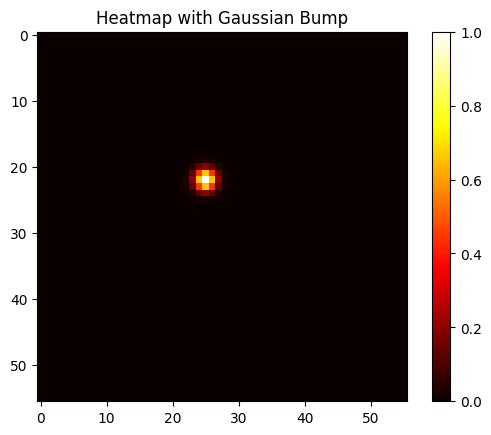

In [5]:
def draw_gaussian(heatmap, center, radius):
    """
    Draws a 2D Gaussian "bump" onto a heatmap.

    Args:
        heatmap (np.ndarray): A 2D numpy array of shape (H, W) representing one
                              channel of the target heatmap.
        center (tuple): The (x, y) integer coordinates of the center of the bump.
        radius (int): The integer radius of the Gaussian bump.
    """
    # The diameter of the patch to calculate
    diameter = 2 * radius + 1
    
    # If the radius is 0, we don't need to do anything
    if radius == 0:
        return heatmap

    # Create a grid of x and y coordinates for the patch
    x = np.arange(0, diameter, 1, float)
    y = np.arange(0, diameter, 1, float)[:, np.newaxis]
    
    # The center of the patch is at (radius, radius)
    x0 = y0 = radius
    
    # Calculate the Gaussian. Sigma is derived from the radius.
    sigma = diameter / 10
    g = np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

    # Get the integer coordinates of the center on the main heatmap
    center_x, center_y = center

    # Determine the boundaries of where to place the patch on the heatmap
    # This handles edge cases where the object is near the border.
    left = min(center_x, radius)
    right = min(heatmap.shape[1] - 1 - center_x, radius)
    top = min(center_y, radius)
    bottom = min(heatmap.shape[0] - 1 - center_y, radius)
    
    # Select the slice of the heatmap to be updated
    masked_heatmap = heatmap[center_y - top : center_y + bottom + 1, 
                             center_x - left : center_x + right + 1]
    
    # Select the corresponding slice from the generated Gaussian patch
    masked_gaussian = g[radius - top : radius + bottom + 1,
                        radius - left : radius + right + 1]
    
    # Place the Gaussian on the heatmap by taking the maximum value.
    # This is important for handling overlapping objects of the same class.
    if masked_heatmap.shape == masked_gaussian.shape:
        np.maximum(masked_heatmap, masked_gaussian, out=masked_heatmap)
        
    return heatmap

# --- Example Usage ---
# Create a blank 56x56 heatmap channel
heatmap_channel = np.zeros((56, 56), dtype=np.float32)

# Define our object's properties
center_point = (25, 22) # (x, y)
# Let's assume the radius on the feature map is 3
# (e.g., original radius was 11, downsampled by 4 -> ~2.75, ceil -> 3)
feature_map_radius = 5

# Draw the gaussian
draw_gaussian(heatmap_channel, center_point, feature_map_radius)

# Check the values
print(f"Value at center (25, 22): {heatmap_channel[22, 25]:.4f}")
print(f"Value at neighbor (26, 22): {heatmap_channel[22, 26]:.4f}")
print(f"Value at neighbor (24, 23): {heatmap_channel[23, 24]:.4f}")
print(f"Value far away (30, 22): {heatmap_channel[22, 30]:.4f}") # Should be 0.0

# Visualize it (requires matplotlib)
try:
    import matplotlib.pyplot as plt
    plt.imshow(heatmap_channel, cmap='hot')
    plt.title("Heatmap with Gaussian Bump")
    plt.colorbar()
    plt.show()
except ImportError:
    print("\nMatplotlib not installed. Cannot visualize heatmap.")

In [6]:
def data_generator(train_data, batch_size, INPUT_SIZE=224, FEATURE_MAP_SIZE=56, NUM_CLASSES=1):
    """
    Generator yielding (batch_images, [heatmap, size_with_mask, offset_with_mask]) without preloading all images
    """
    num_samples = len(train_data)
    indices = np.arange(num_samples)
    DOWNSAMPLING_RATIO = INPUT_SIZE / FEATURE_MAP_SIZE

    while True:
        np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = start + batch_size
            batch_idx = indices[start:end]
            
            batch_images = np.zeros((len(batch_idx), INPUT_SIZE, INPUT_SIZE, 3), dtype=np.float32)
            heatmaps     = np.zeros((len(batch_idx), FEATURE_MAP_SIZE, FEATURE_MAP_SIZE, NUM_CLASSES), dtype=np.float32)
            size_maps    = np.zeros((len(batch_idx), FEATURE_MAP_SIZE, FEATURE_MAP_SIZE, 2), dtype=np.float32)
            offset_maps  = np.zeros((len(batch_idx), FEATURE_MAP_SIZE, FEATURE_MAP_SIZE, 2), dtype=np.float32)
            masks        = np.zeros((len(batch_idx), FEATURE_MAP_SIZE, FEATURE_MAP_SIZE), dtype=np.float32)

            for b, idx in enumerate(batch_idx):
                x = train_data[idx]
                w_img, h_img = x['width'], x['height']
                image = cv2.imread(x['filename'])
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (INPUT_SIZE, INPUT_SIZE)).astype(np.float32) 

                batch_images[b] = image

                for obj in x['object']:
                    xmin = obj['xmin'] * INPUT_SIZE / w_img
                    xmax = obj['xmax'] * INPUT_SIZE / w_img
                    ymin = obj['ymin'] * INPUT_SIZE / h_img
                    ymax = obj['ymax'] * INPUT_SIZE / h_img

                    cx = (xmin + xmax) / 2
                    cy = (ymin + ymax) / 2
                    bw = xmax - xmin
                    bh = ymax - ymin
                    class_id = LABELS.index(obj['name'])

                    fx, fy = cx / DOWNSAMPLING_RATIO, cy / DOWNSAMPLING_RATIO
                    px, py = int(fx), int(fy)

                    if px < 0 or px >= FEATURE_MAP_SIZE or py < 0 or py >= FEATURE_MAP_SIZE:
                        continue

                    radius = calculate_gaussian_radius((bh, bw), min_overlap=0.1) / DOWNSAMPLING_RATIO
                    radius = max(1, round(radius))
                    draw_gaussian(heatmaps[b, :, :, class_id], (px, py), radius)

                    off_x, off_y = fx - px, fy - py
                    size_maps[b, py, px, :]   = [bw, bh]
                    offset_maps[b, py, px, :] = [off_x, off_y]
                    masks[b, py, px]          = 1.0

            size_with_mask   = np.concatenate([size_maps,   masks[..., np.newaxis]], axis=-1)
            offset_with_mask = np.concatenate([offset_maps, masks[..., np.newaxis]], axis=-1)

            y_true_dict = {
                'heatmap_out': heatmaps,
                'size_out': size_with_mask,
                'offset_out': offset_with_mask
            }

            yield batch_images, y_true_dict

ds = data_generator(train_image, batch_size=64, NUM_CLASSES=NUM_CLASSES)
batch_images, y_true = next(ds)

print("batch_images shape:",     batch_images.shape)
print("heatmap_out shape:",      y_true['heatmap_out'].shape)
print("size_out shape:",         y_true['size_out'].shape)
print("offset_out shape:",       y_true['offset_out'].shape)

batch_images shape: (64, 224, 224, 3)
heatmap_out shape: (64, 56, 56, 20)
size_out shape: (64, 56, 56, 3)
offset_out shape: (64, 56, 56, 3)


In [7]:
@register_keras_serializable("Custom")
class MLPDecoder(layers.Layer):
    def __init__(self, embedding_dim, num_classes, name="mlp_decoder", **kwargs):
        super().__init__(name=name, **kwargs)

        # Heatmap Head
        self.heatmap_head = tf.keras.Sequential([
            layers.Conv2D(embedding_dim, 3, padding="same", activation='relu'),
            layers.Conv2D(num_classes, 1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(-2.19))
        ], name='heatmap_head')

        # Size Head
        self.size_head = tf.keras.Sequential([
            layers.Conv2D(embedding_dim, 3, padding="same", activation='relu'),
            layers.Conv2D(2, 1, activation=None)
        ], name='size_head')

        # Offset Head
        self.offset_head = tf.keras.Sequential([
            layers.Conv2D(embedding_dim, 3, padding="same", activation='relu'),
            layers.Conv2D(2, 1, activation=None)
        ], name='offset_head')

    def call(self, features):
        heatmap = self.heatmap_head(features)
        size = self.size_head(features)
        offset = self.offset_head(features)
        return heatmap, size, offset
    
@register_keras_serializable("Custom")
class FeatureExtractor(layers.Layer):
    def __init__(self, input_shape=(224, 224, 3), weights_path="weights_mobilenet_v3_small_224_1.0_float_no_top_v2.h5", **kwargs):
        super().__init__(**kwargs)
        self.backbone = MobileNetV3Small(input_shape=input_shape,
                                         weights=None,
                                         include_top=False,
                                         pooling=None)
        if weights_path:
            self.backbone.load_weights(weights_path)
        self.backbone.trainable = False

        self.up_stack = Sequential([
            layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU(),

            layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU(),

            layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU()
        ], name="upsample_stack")

    def call(self, x):
        x = self.backbone(x)
        x = self.up_stack(x)
        return x
    
@register_keras_serializable("Custom")
class BuildCenterNet(tf.keras.Model):
    def __init__(self, input_shape=(224, 224, 3), num_classes=20, decoder_embedding_dim=64,**kwargs):
        super().__init__(name='CenterNet',**kwargs)

        self.backbone = FeatureExtractor(input_shape=input_shape)
        self.decoder = MLPDecoder(embedding_dim=decoder_embedding_dim, num_classes=num_classes)
        self._input_shape = input_shape

    def call(self, inputs):
        x = self.backbone(inputs)
        heatmap, size, offset = self.decoder(x)
        return {'heatmap_out': heatmap, 'size_out': size, 'offset_out': offset}

    def get_model(self):
        inp = layers.Input(shape=self._input_shape)
        out = self.call(inp)       
        return Model(inp, out, name=f"{self.name}_model")
    
centernet = BuildCenterNet(input_shape=(224, 224, 3), num_classes=NUM_CLASSES, decoder_embedding_dim=64)
detector = centernet.get_model()
detector.summary()

2025-07-14 11:45:17.466835: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-07-14 11:45:17.466861: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-07-14 11:45:17.466867: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
I0000 00:00:1752473717.466880   31653 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1752473717.466894   31653 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "CenterNet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_extractor               │ (None, 56, 56, 128)    │     2,644,592 │
│ (FeatureExtractor)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mlp_decoder (MLPDecoder)        │ [(None, 56, 56, 20),   │       222,936 │
│                                 │ (None, 56, 56, 2),     │               │
│                                 │ (None, 56, 56, 2)]     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,867,528 (10.94 MB)

 Trainable params: 1,927,640 (7.35 MB)

 Non-trainable params: 939,888 (3.59 MB)

In [8]:
def masked_l1_loss(y_true_with_mask, y_pred):
    """
    Calculates a masked L1 loss for the size and offset heads.
    
    Args:
        y_true_with_mask (Tensor): Ground truth tensor of shape (batch, H, W, 3).
                                   The first 2 channels are the targets (w,h or dx,dy).
                                   The 3rd channel is the binary mask.
        y_pred (Tensor): The model's prediction of shape (batch, H, W, 2).
                         
    Returns:
        Tensor: A scalar loss value.
    """
    # 1. Unpack the ground truth targets and the mask
    y_true = y_true_with_mask[..., :2]  # Shape: (batch, 56, 56, 2)
    mask   = y_true_with_mask[..., 2]   # Shape: (batch, 56, 56)

    # 2. Calculate the L1 error for all pixels
    absolute_error = tf.abs(y_true - y_pred)

    # 3. Apply the mask to ignore pixels that are not object centers.
    # We expand the mask's dimensions to match the error tensor for multiplication
    masked_error = absolute_error * tf.expand_dims(mask, axis=-1)

    # 4. Sum the error and normalize by the number of objects in the batch.
    # Add a small epsilon to prevent division by zero if a batch has no objects.
    num_objects = tf.reduce_sum(mask) + 1e-8
    total_loss = tf.reduce_sum(masked_error) / num_objects
    return total_loss

def focal_loss(y_true, y_pred,
                         alpha=2.0,  # focusing exponent
                         beta =4.0,  # extra negative exponent
                         eps  =1e-4):
    """
    CenterNet-style focal loss for heat-map heads.

    Args
    ----
    y_true: (B,H,W,C) float32, Gaussian bumps (centre == 1).
    y_pred: (B,H,W,C) float32, after sigmoid.
    alpha : float, focusing exponent (paper uses 2).
    beta  : float, exponent for negatives (paper uses 4).

    Returns
    -------
    scalar Tensor
    """
    # Clip prediction for log stability
    y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)

    pos_inds = tf.cast(tf.equal(y_true, 1.0), tf.float32)
    neg_inds = tf.cast(tf.less(y_true, 1.0), tf.float32)

    # Positive loss: -(1-ŷ)^α log(ŷ)
    pos_loss = - tf.pow(1. - y_pred, alpha) * tf.math.log(y_pred) * pos_inds

    # Negative loss: -(1-y)^β ŷ^α log(1-ŷ)
    neg_weight = tf.pow(1. - y_true, beta)
    neg_loss = - tf.pow(y_pred,   alpha) * tf.math.log(1. - y_pred) * neg_weight * neg_inds

    # Normalise by number of positive centres
    num_pos  = tf.reduce_sum(pos_inds)
    total_loss = tf.reduce_sum(pos_loss + neg_loss)
    return tf.math.divide_no_nan(total_loss, num_pos)

In [9]:
# 1. Define the loss dictionary
loss_dict = {
    'heatmap_out': focal_loss,
    'size_out': masked_l1_loss,
    'offset_out': masked_l1_loss
}

# 2. Define the loss weights dictionary (standard values from the paper)
loss_weights_dict = {
    'heatmap_out': 1.0,
    'size_out': 0.1,
    'offset_out': 1.0
}

# 3. Compile the model
detector.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=loss_dict,
    loss_weights=loss_weights_dict
)

num_samples = len(train_image) 
batch_size = 64
steps_per_epoch = num_samples // batch_size 

history = detector.fit(ds, epochs=70, steps_per_epoch=steps_per_epoch)
print("Training finished!")

Epoch 1/70


2025-07-14 00:37:16.107359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


267/267 ━━━━━━━━━━━━━━━━━━━━ 105s 374ms/step - heatmap_out_loss: 36.8444 - loss: 52.8024 - offset_out_loss: 0.8008 - size_out_loss: 151.5705
Epoch 2/70
267/267 ━━━━━━━━━━━━━━━━━━━━ 99s 369ms/step - heatmap_out_loss: 4.0102 - loss: 12.2679 - offset_out_loss: 0.5233 - size_out_loss: 77.3445
Epoch 3/70
267/267 ━━━━━━━━━━━━━━━━━━━━ 99s 372ms/step - heatmap_out_loss: 3.5941 - loss: 10.3378 - offset_out_loss: 0.5091 - size_out_loss: 62.3899
Epoch 4/70
267/267 ━━━━━━━━━━━━━━━━━━━━ 98s 367ms/step - heatmap_out_loss: 3.2900 - loss: 9.3150 - offset_out_loss: 0.5019 - size_out_loss: 55.2574
Epoch 5/70
267/267 ━━━━━━━━━━━━━━━━━━━━ 98s 366ms/step - heatmap_out_loss: 3.1309 - loss: 8.4248 - offset_out_loss: 0.4988 - size_out_loss: 47.9812
Epoch 6/70
267/267 ━━━━━━━━━━━━━━━━━━━━ 103s 387ms/step - heatmap_out_loss: 3.0379 - loss: 7.6864 - offset_out_loss: 0.4928 - size_out_loss: 41.5670
Epoch 7/70
267/267 ━━━━━━━━━━━━━━━━━━━━ 99s 372ms/step - heatmap_out_loss: 2.9494 - loss: 7.1113 - offset_out_loss: 

In [10]:
import tf2onnx
import tensorflow as tf

spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)

onnx_model, _ = tf2onnx.convert.from_keras(
    detector,
    input_signature=spec,
    opset=13,  # or 17 depending on your deployment needs
    output_path="centernet_inference.onnx"
)

detector.save('centernet_mobilenetv3S.keras')

detector.compile()  # resets training state (optimizer, loss, metrics)
detector.save("centernet_inference.keras", include_optimizer=False)

I0000 00:00:1752440718.417964 7390683 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1752440718.418033 7390683 single_machine.cc:374] Starting new session
I0000 00:00:1752440718.418184 7390683 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1752440718.418195 7390683 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
I0000 00:00:1752440719.243544 7390683 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1752440719.243563 7390683 pluggable_device_factory.cc:271] Created TensorFlow device (/job:l

In [9]:
# Model and training constants
INPUT_SIZE = 224
DOWNSAMPLING_RATIO = 4

def decode_detections(heatmap, size_map, offset_map, threshold):
    """
    Decodes the raw model outputs into a list of detected bounding boxes.
    """
    # --- THIS IS THE FIX ---
    # Convert all input tensors to NumPy arrays to use NumPy's indexing capabilities.
    heatmap = heatmap
    size_map = size_map
    offset_map = offset_map
    # --------------------

    # Get the shape of the heatmap
    batch_size, height, width, num_classes = heatmap.shape

    # 1. Perform a 3x3 max-pooling on the heatmap to find peaks.
    heatmap_tf = tf.convert_to_tensor(heatmap) 
    heatmap_pooled = tf.nn.max_pool2d(heatmap_tf, ksize=3, strides=1, padding='SAME')
    
    # Now convert the pooled result back to NumPy
    heatmap_pooled_np = heatmap_pooled.numpy()
    
    # Keep only the peaks
    peaks = (heatmap == heatmap_pooled_np)
    heatmap_peaks = heatmap * peaks

    # 2. Get the coordinates, scores, and class IDs of all peaks above the threshold
    y_coords, x_coords, class_ids = np.where(heatmap_peaks[0] > threshold)
    
    # The following lines will now work perfectly because all arrays are NumPy arrays.
    scores = heatmap_peaks[0, y_coords, x_coords, class_ids]

    # 3. Retrieve the corresponding size and offset predictions for each peak
    pred_sizes = size_map[0, y_coords, x_coords, :]
    pred_offsets = offset_map[0, y_coords, x_coords, :]

    # 4. Decode each peak into a bounding box
    boxes, decoded_scores, decoded_labels = [], [], []
    for i in range(len(x_coords)):
        score = scores[i]
        class_id = class_ids[i]
        px, py = x_coords[i], y_coords[i]
        w, h = pred_sizes[i]
        off_x, off_y = pred_offsets[i]

        center_x = (px + off_x) * DOWNSAMPLING_RATIO
        center_y = (py + off_y) * DOWNSAMPLING_RATIO

        x_min = center_x - w / 2
        y_min = center_y - h / 2
        x_max = center_x + w / 2
        y_max = center_y + h / 2
        
        boxes.append([x_min, y_min, x_max, y_max])
        decoded_scores.append(score)
        decoded_labels.append(class_id)
        
    return np.array(boxes), np.array(decoded_scores), np.array(decoded_labels)

In [10]:
from keras.models import load_model

detector = load_model(
    "centernet_inference.keras",
    custom_objects={"FeatureExtractor": FeatureExtractor},
    compile=False
)

/Users/saptarshimallikthakur/Desktop/Extraas/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'feature_extractor_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/saptarshimallikthakur/Desktop/Extraas/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'mlp_decoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


2025-07-14 11:45:38.646916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


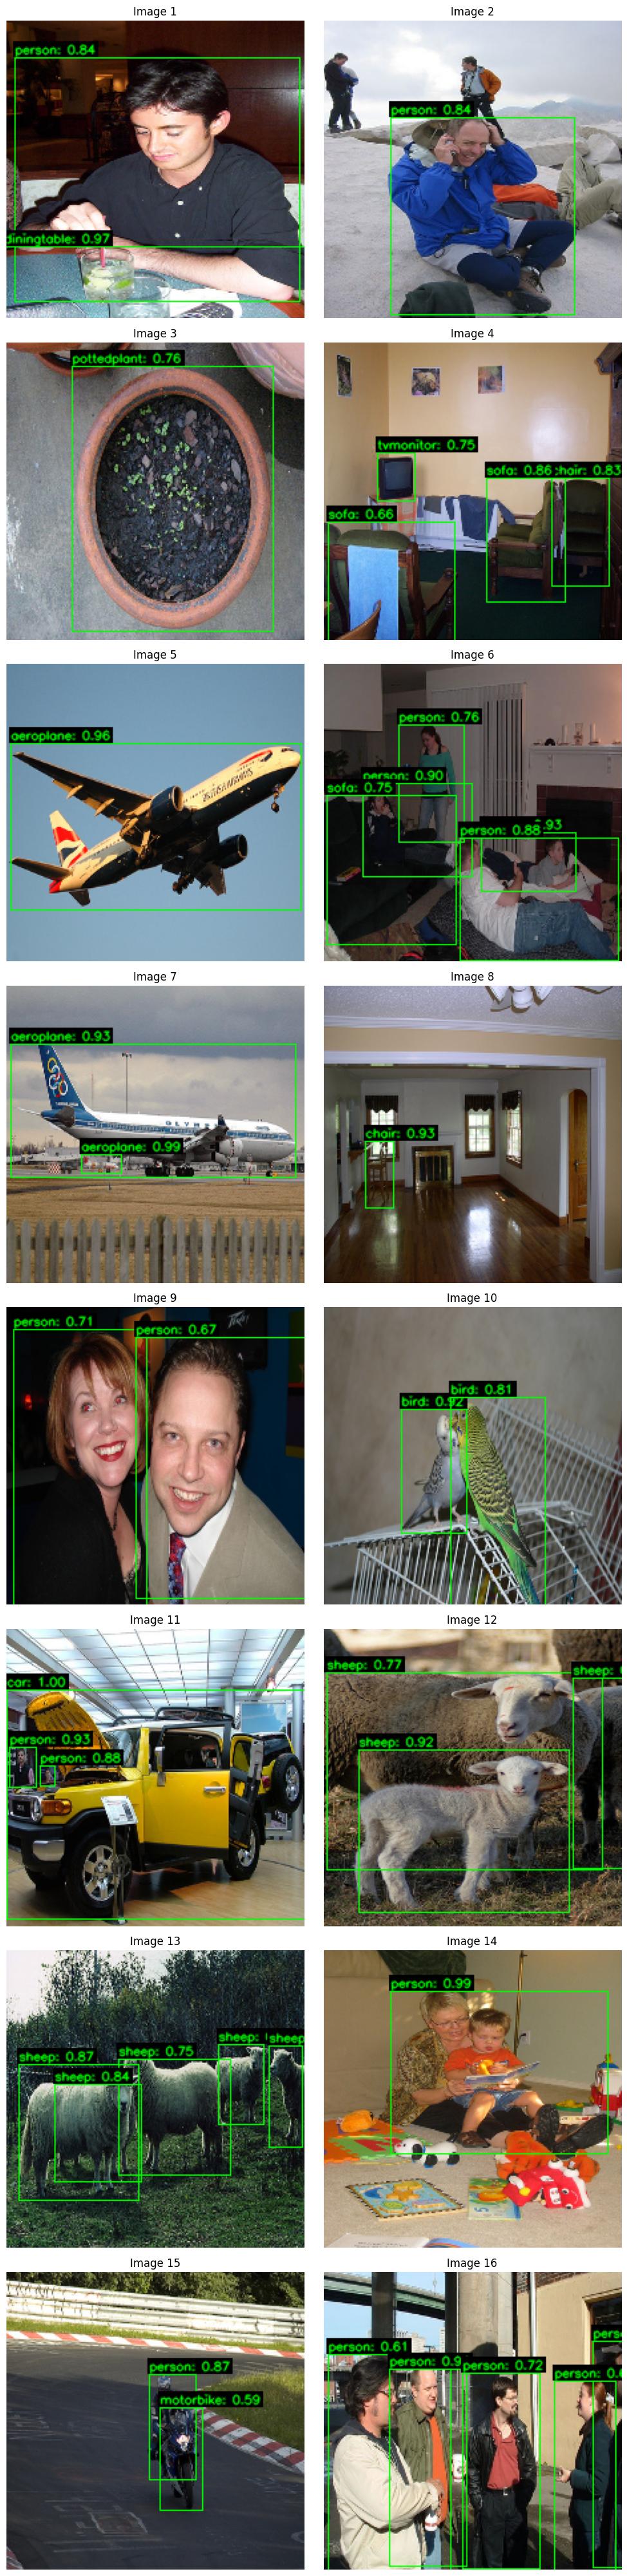

In [11]:
# Run model predictions
batch_images, y_true = next(ds)
predictions = detector.predict(batch_images,verbose=False)

# Extract outputs
pred_heatmap = predictions['heatmap_out']
pred_size = predictions['size_out']
pred_offset = predictions['offset_out']

batch_size = batch_images.shape[0]
num_cols = 2
num_rows = math.ceil(batch_size / num_cols)

plt.figure(figsize=(10, 5 * num_rows))

for idx in range(16):
    input_tensor = batch_images[idx:idx+1]

    # De-normalize and convert to displayable image
    original_image = input_tensor[0].copy()
    original_image = original_image.astype('uint8')

    # Decode predictions for this image
    boxes, scores, labels = decode_detections(
        pred_heatmap[idx:idx+1],
        pred_size[idx:idx+1],
        pred_offset[idx:idx+1],
        threshold=0.5
    )

    # Draw predictions
    for i in range(len(boxes)):
        x_min, y_min, x_max, y_max = boxes[i].astype(int)
        score = scores[i]
        label_id = int(labels[i])
        label_name = LABELS[label_id]
        text = f"{label_name}: {score:.2f}"

        # Draw bounding box
        cv2.rectangle(original_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)

        # Text setup
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.3
        thickness = 1
        (text_width, text_height), _ = cv2.getTextSize(text, font, font_scale, thickness)

        # Bottom-left corner of bounding box
        text_x = x_min
        text_y = y_min - text_height + 4  # small padding below box

        # Background rectangle
        cv2.rectangle(original_image,
                    (text_x - 1, text_y - text_height - 2),
                    (text_x + text_width + 1, text_y + 2),
                    (0, 0, 0), -1)

        # Green text
        cv2.putText(original_image, text, (text_x, text_y),
                    font, font_scale, (0, 255, 0), thickness, cv2.LINE_AA)

    # Plot the image
    plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(original_image)
    plt.axis('off')
    plt.title(f"Image {idx + 1}")

plt.tight_layout()
plt.show()